In [1]:
import warnings

from yellowbrick.cluster import KElbowVisualizer


pal = [(39/255,95/255,153/255),
       (80/255,176/255,220/255),
       (237/255,244/255,248/255),
       (146/255,144/255,142/255),
       (78/255,78/255,80/255),
        (235/255,154/255,88/255),
       (87/255,126/255,130/255)]

import sklearn.cluster
import sklearn_extra.cluster

import matplotlib.colors as mcolors
import umap.umap_ as umap
import phate
import sklearn.cluster
import numpy as np
import argparse
import cv2
from phate import cluster_custom
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import venn


from tqdm import tqdm
import sys
sys.path.append("/Users/rcarlson/Documents/GitHub/lasagna3/snakes")
import mahotas
from ops.imports_ipython import *

import skimage
import umap.umap_ as umap
import stringdb
import pandas as pd

from dask import compute, delayed
from dask.distributed import Client
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import igraph as ig
from sklearn.neighbors import kneighbors_graph

import leidenalg
import gseapy as gp

scaler = StandardScaler()
import magic

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

### ROC curve

In [2]:
### Define true hits

lowhits = ['MAVS', 'DDX58', 'ATP13A1', 'RNF135', 'IRF3', 'IRF2', 'NCOR2', 'IKBKG',
           
           'SLC35A1','GNE','CMAS','ATP2B1','ADNP','LIN37','ACTR6', 'SEC61B',
           'COG7','KLHL15','CAPN15','PIP4K2C','PDS5A',
          'FBXO11','FBXW7','FZR1']


highhits = ['PRDM1', 'STAT3', 
            'PDCD10','MAP2K6','CCNC','MED13','MED24','MED16','BTAF1',
            'ALG1L2','DIS3L','POGZ','VPS11','VPS16','VPS39',
            'SEPHS1','CAB39','MAU2','AKIRIN1',
            'TADA2B','TAF5L','TAF6L',
            'FLCN','RRAGC','LAMTOR2','LAMTOR3','LAMTOR5'
           ]

defined = pd.read_csv('../Data/TableS3.csv')

truehits = lowhits + highhits
nothits = [g for g in defined[~(pd.isnull(defined.mean_transloc_secondary_antibody)) & ~(pd.isnull(defined.mean_transloc_secondary_reporter))].gene_symbol if g not in truehits]

negnothits = defined.loc[(defined.gene_symbol.isin(nothits)) & 
          (defined.mean_transloc_primary < 0)].gene_symbol
negtruehits = defined.loc[(defined.gene_symbol.isin(truehits)) & 
          (defined.mean_transloc_primary < 0)].gene_symbol
posnothits = defined.loc[(defined.gene_symbol.isin(nothits)) & 
          (defined.mean_transloc_primary > 0)].gene_symbol
postruehits = defined.loc[(defined.gene_symbol.isin(truehits)) & 
          (defined.mean_transloc_primary > 0)].gene_symbol

In [15]:
def grp_df(sg_df_loc):
    grped = pd.read_hdf(sg_df_loc)
    nt = grped[grped.gene == "nontargeting"]
    bcls = ([nt.cell_barcode_0[i:i + 3] for i in range(0, len(nt.cell_barcode_0), 3)])
    grped['gene_og'] = grped['gene']
    for i in range(len(bcls)):
        grped.loc[grped.cell_barcode_0.isin(bcls[i]),'gene'] = 'nontargeting_' + str(i)
    grped = grped.groupby(['gene','gene_og']).mean().reset_index()
    grped.reset_index(inplace = True)
    return grped

In [97]:
loc = '../../Zenodo_IRF3/DeepLearning/Transfer/Features/tf_df_feats_ch2_grped_sgonly.hdf'

transfer = grp_df(loc)
transfer = transfer[transfer.gene.isin(truehits + nothits)]
transfer.loc[transfer.gene.isin(nothits),'hit_status'] = 'not hit'
transfer.loc[transfer.gene.isin(negtruehits),'hit_status'] = 'neg'
transfer.loc[transfer.gene.isin(postruehits),'hit_status'] = 'pos'

loc = '../../Zenodo_IRF3/DeepLearning/Autoencoder/Features/ae_df_feats_ch2_grped_sgonly.hdf'

autoencoder = grp_df(loc)
autoencoder = autoencoder[autoencoder.gene.isin(truehits + nothits)]
autoencoder.loc[autoencoder.gene.isin(nothits),'hit_status'] = 'not hit'
autoencoder.loc[autoencoder.gene.isin(negtruehits),'hit_status'] = 'neg'
autoencoder.loc[autoencoder.gene.isin(postruehits),'hit_status'] = 'pos'

defined = defined[defined.gene_symbol.isin(transfer.gene)]
defined.loc[defined.gene_symbol.isin(nothits),'hit_status'] = 'not hit'
defined.loc[defined.gene_symbol.isin(negtruehits),'hit_status'] = 'neg'
defined.loc[defined.gene_symbol.isin(postruehits),'hit_status'] = 'pos'


In [103]:
## Train classifier defined
Xm = np.array(defined[defined.gene_symbol.isin(nothits + truehits)].mean_transloc_primary)[:,np.newaxis]
factor = pd.factorize(defined[defined.gene_symbol.isin(nothits + truehits)].hit_status)
defined['hit_status'] = factor[0]
defined.definitions = factor[1]
ym = defined.hit_status
X_train, X_test, y_train, y_test, gene_train, gene_test = train_test_split(Xm, ym, defined.gene_symbol, test_size=0.3, shuffle=True, 
                                                                           random_state = 8)

rf = RandomForestClassifier(n_estimators = 1000, random_state = 7, max_depth = 100)
rf.fit(X_train, y_train)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = rf.predict_proba(X_test)

n_classes = 3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test_bin)[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["defined"] = all_fpr
tpr["defined"] = mean_tpr
roc_auc["defined"] = auc(fpr["defined"], tpr["defined"])

## Train classifier transfer
factor = pd.factorize(transfer[transfer.gene.isin(nothits + truehits)].hit_status)
transfer['hit_status'] = factor[0]
transfertrain = transfer[transfer.gene.isin(gene_train)]
transfertest = transfer[transfer.gene.isin(gene_test)]
X_train = np.array(transfertrain.loc[:, transfer.columns.str.startswith('cnn')])
X_test = np.array(transfertest.loc[:, transfer.columns.str.startswith('cnn')])
y_train = transfertrain.hit_status
y_test = transfertest.hit_status


rf = RandomForestClassifier(n_estimators = 1000, random_state = 7, max_depth = 100)
rf.fit(X_train, y_train)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = rf.predict_proba(X_test)

n_classes = 3
# Compute ROC curve and ROC area for each class
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test_bin)[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["transfer"] = all_fpr
tpr["transfer"] = mean_tpr
roc_auc["transfer"] = auc(fpr["transfer"], tpr["transfer"])

## Train classifier autoencoder
factor = pd.factorize(autoencoder[autoencoder.gene.isin(nothits + truehits)].hit_status)
autoencoder['hit_status'] = factor[0]
autoencodertrain = autoencoder[autoencoder.gene.isin(gene_train)]
autoencodertest = autoencoder[autoencoder.gene.isin(gene_test)]
X_train = np.array(autoencodertrain.loc[:, autoencoder.columns.str.startswith('ae')])
X_test = np.array(autoencodertest.loc[:, autoencoder.columns.str.startswith('ae')])
y_train = autoencodertrain.hit_status
y_test = autoencodertest.hit_status


rf = RandomForestClassifier(n_estimators = 1000, random_state = 7, max_depth = 100)
rf.fit(X_train, y_train)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = rf.predict_proba(X_test)

n_classes = 3
# Compute ROC curve and ROC area for each class
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test_bin)[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["autoencoder"] = all_fpr
tpr["autoencoder"] = mean_tpr
roc_auc["autoencoder"] = auc(fpr["autoencoder"], tpr["autoencoder"])

## Train classifier combined

cnnmean = transfer.loc[:,transfer.columns.str.contains('feat')].mean(axis = 0).mean()
aemean = autoencoder.loc[:,autoencoder.columns.str.contains('feat')].mean(axis = 0).mean()
combined = pd.merge(transfer, autoencoder,on = 'gene')



factor = pd.factorize(combined[combined.gene.isin(nothits + truehits)].hit_status_x)
combined['hit_status'] = factor[0]
combinedtrain = combined[combined.gene.isin(gene_train)]
combinedtest = combined[combined.gene.isin(gene_test)]
X_train = np.array(combinedtrain.loc[:, combined.columns.str.contains('feat')])
X_test = np.array(combinedtest.loc[:, combined.columns.str.contains('feat')])
y_train = combinedtrain.hit_status
y_test = combinedtest.hit_status


rf = RandomForestClassifier(n_estimators = 1000, random_state = 7, max_depth = 100)
rf.fit(X_train, y_train)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = rf.predict_proba(X_test)

n_classes = 3
# Compute ROC curve and ROC area for each class
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test_bin)[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["combined"] = all_fpr
tpr["combined"] = mean_tpr
roc_auc["combined"] = auc(fpr["combined"], tpr["combined"])

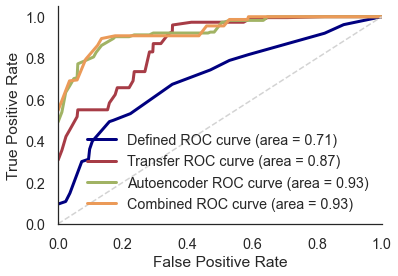

In [122]:
# Plot all ROC curves
lw = 3
sns.set(font_scale=1.3)
sns.set_style('white')


plt.figure(figsize = (5.8,4))

plt.plot(fpr["defined"], tpr["defined"],
         label='Defined ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["defined"]),
         color='navy', linewidth=lw)

plt.plot(fpr["transfer"], tpr["transfer"],
         label='Transfer ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["transfer"]),
         color=pal[0], linewidth=lw)

plt.plot(fpr["autoencoder"], tpr["autoencoder"],
         label='Autoencoder ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["autoencoder"]),
         color=pal[2], linewidth=lw)

plt.plot(fpr["combined"], tpr["combined"],
         label='Combined ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["combined"]),
         color=pal[4], linewidth=lw)

    
plt.plot([0, 1], [0, 1], 'lightgray', linestyle =  '--', lw=lw*.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
sns.despine(top = True, right = True)

plt.savefig('rf.tif',dpi=600,bbox_inches = 'tight')
plt.show()

### IRF3 Translocation Barplot

In [72]:

df = pd.read_hdf('../Data/F3/m157-158.hdf')

ctrls =  ['nontargeting', 'DDX58', 'MAVS']
sorter = ctrls + list(df[~df.gene.isin(ctrls)].groupby('gene').dapi_gfp_corr_nuclear.mean().sort_values().index)
df.gene = df.gene.astype('category')

df.gene.cat.set_categories(sorter, inplace=True)
df = df.sort_values(["gene"])
df.gene = df.gene.astype('string')
df.loc[df.sgRNA.str.endswith('_2'),'sgRNA'] = [s.split('_2')[0] + '_0' for s in df[df.sgRNA.str.endswith('_2')].sgRNA]


#

4816579
gate applied, retained  73 % of data
number nt 6000
dapi_gfp_corr_nuclear
auc done
            gene  n_sg  fisher_combined_chi          pval  fdr_bh_adj_p  \
0   nontargeting   2.0             1.871671  7.593470e-01  7.593470e-01   
1          DDX58   2.0            92.854369  3.258047e-19  5.538679e-18   
2           MAVS   2.0            85.046191  1.483112e-17  1.260645e-16   
3           PPA2   2.0            57.680281  8.906086e-12  5.046782e-11   
4         FAM98B   2.0            34.099236  7.110710e-07  3.022052e-06   
5           COA5   2.0            30.950538  3.133348e-06  1.065338e-05   
6        ANKRD63   2.0            24.075549  7.713729e-05  1.962939e-04   
7           GCAT   2.0            18.060935  1.200712e-03  2.551513e-03   
8          TIPRL   2.0            23.974324  8.082691e-05  1.962939e-04   
9       MTRNR2L4   2.0            15.205546  4.293349e-03  8.109659e-03   
10       PLEKHB1   2.0            13.195779  1.035776e-02  1.760819e-02   
11       

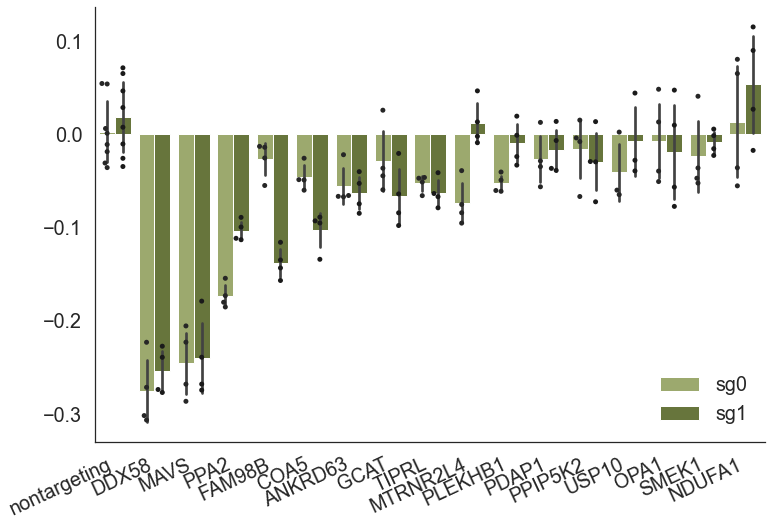

In [76]:
from ops.firedove_barplots import *
aucs, grped = produce_barplot_general(df,  df_name = 'm157-8', pshow = True, 
                                    genes = pd.unique(df.gene),
            gate = '100 < i <1380 & 100 < j < 1380 & area <= 300 & area > 10 & dapi_max_nuclear < 20000',
                    replist = [1,2,3,4],  nbins=50,  
                        feature='dapi_gfp_corr_nuclear', plot_nt = False, range_vals = (-1,.7), pal = 'green',
                   alpha=.05, pval_sort = True)

##

### Pex volcano plot

In [2]:
xls = pd.ExcelFile('../Data/TableS4.xls')
df = pd.read_excel(xls, 'Pex_cell_max')
df.index = df.gene_symbol

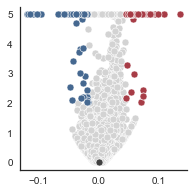

In [3]:
fdrthresh = .01
topn = 50
sns.set_style('white')
pexdowngenesvolcano = (df.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[:topn].index)
pexupgenesvolcano = (df.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[-topn:].index)

plt.figure(figsize = (3,3))
sns.scatterplot(x = df['mean'], y = -np.log10(df.fdr_bh_adj_p), color=mcolors.to_rgba('#d3d3d3'))
sns.scatterplot(x = df[df.index == "nontargeting"]['mean'], y = -np.log10(df[df.index== "nontargeting"].fdr_bh_adj_p), 
                color = mcolors.to_rgba('#404040'))
sns.scatterplot(x = df[df.index.isin(pexdowngenesvolcano)]['mean'], 
                y = -np.log10(df[df.index.isin(pexdowngenesvolcano)].fdr_bh_adj_p), color = pal[1])
sns.scatterplot(x = df[df.index.isin(pexupgenesvolcano)]['mean'], 
                y = -np.log10(df[df.index.isin(pexupgenesvolcano)].fdr_bh_adj_p), color = pal[0])

sns.despine(top = True, right = True)
plt.xlabel('')
plt.ylabel('')
plt.savefig('../../../IRF3 Paper/Figures/F3/volcano_pex_cell_max.tif', dpi = 600, bbox_inches = 'tight')
plt.show()
#

In [16]:
tmp = df.query('fdr_bh_adj_p < @fdrthresh')
tmp.sort_values('mean')[:30]

,gene_symbol,mean,n_sg,fisher_combined_chi,2_sided_p_value,fdr_bh_adj_p,significant
gene_symbol,,,,,,,
ADSS,ADSS,-0.118418,1,inf,0.000000e+00,0.000010,True
PEX13,PEX13,-0.117061,4,inf,0.000000e+00,0.000010,True
PEX2,PEX2,-0.114550,4,inf,0.000000e+00,0.000010,True
PEX14,PEX14,-0.108918,3,inf,0.000000e+00,0.000010,True
PEX1,PEX1,-0.104314,4,inf,0.000000e+00,0.000010,True
ZCCHC14,ZCCHC14,-0.103306,3,inf,0.000000e+00,0.000010,True
PEX12,PEX12,-0.099947,4,inf,0.000000e+00,0.000010,True
PEX10,PEX10,-0.096366,4,inf,0.000000e+00,0.000010,True
PEX6,PEX6,-0.095269,4,inf,0.000000e+00,0.000010,True


### Pex Gene Ontology

##### Define functions

In [40]:
def grp_df(sg_df_loc):
    grped = pd.read_hdf(sg_df_loc)
    nt = grped[grped.gene == "nontargeting"]
    bcls = ([nt.cell_barcode_0[i:i + 3] for i in range(0, len(nt.cell_barcode_0), 3)])
    grped['gene_og'] = grped['gene']
    for i in range(len(bcls)):
        grped.loc[grped.cell_barcode_0.isin(bcls[i]),'gene'] = 'nontargeting_' + str(i)
    grped = grped.groupby(['gene','gene_og']).mean().reset_index()

    df = pd.read_hdf('../Data/TableS1.hdf')
    grped = pd.merge(grped, df, left_on = 'gene_og', right_index = True, how = 'inner')
    grped.reset_index(inplace = True)
    return grped


def calc_phate(df, colstart):
    phate_op = phate.PHATE(n_components = 10, n_jobs = -1, random_state = 7, knn = 5, t = 10, gamma = 0) 
    dfphate = phate_op.fit_transform(df.loc[:,df.columns.str.startswith(colstart)])
    return dfphate, phate_op

def plot_phate_enrichr_definedgenes(loc, dfphate, geneslow, geneshigh, name):

    grped = grp_df(loc)
    dfu = pd.concat([pd.DataFrame(dfphate[:,:2]),grped],axis = 1)
    dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) 

    plt.figure(figsize = (6,6))
    sns.scatterplot(data = dfu, x = 'UMAP1', 
                        y = 'UMAP2', color = mcolors.to_rgba('#d3d3d3'))
   
    sns.scatterplot(data = dfu[dfu.gene.isin(geneslow)], x = 'UMAP1', 
                        y = 'UMAP2', color = pal[1])
    sns.scatterplot(data = dfu[dfu.gene.isin(geneshigh)], x = 'UMAP1', 
                        y = 'UMAP2', color = pal[0])
    sns.scatterplot(data = dfu.query('gene_og == "nontargeting"'), x = 'UMAP1', 
                        y = 'UMAP2',
                    color = mcolors.to_rgba('#404040'))
    sns.despine(top = True, right = True)
    plt.show()

    ##
    i = 0
    fnames = ['low', 'high']
    for genes in [geneslow, geneshigh]:
        k = fnames[i]
        i += 1
        enr = gp.enrichr(gene_list=list(pd.unique(genes)),
                         gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                                   'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                         organism='Human', 
                         outdir='../Data/F3/enrichrterms/%s_phate_enrichr_%s'%(name,k),
                         cutoff=0.05)
        
    return dfu

##### Find GO terms

In [29]:
loc = '../../Zenodo_IRF3/DeepLearning/Transfer/Features/tf_df_feats_ch6_grped_sgonly.hdf'
grped = grp_df(loc)
gphate_pex_tf, gop_pex_tf = calc_phate(grped, colstart = 'cnn')

loc = '../../Zenodo_IRF3/DeepLearning/Autoencoder/Features/ae_df_feats_ch6_grped_sgonly.hdf'
grped = grp_df(loc)
gphate_pex_ae, gop_pex_ae = calc_phate(grped, colstart = 'ae')

Calculating PHATE...
  Running PHATE on 19239 observations and 1228 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.57 seconds.
    Calculating KNN search...
    Calculated KNN search in 10.05 seconds.
    Calculating affinities...
    Calculated affinities in 0.18 seconds.
  Calculated graph and diffusion operator in 14.86 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.94 seconds.
    Calculating KMeans...
    Calculated KMeans in 25.13 seconds.
  Calculated landmark operator in 28.61 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.63 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 222.79 seconds.
Calculated PHATE in 266.91 seconds.
Calculating PHATE...
  Running PHATE on 19239 observations and 1027 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.57 seconds.
    Calculating KNN se

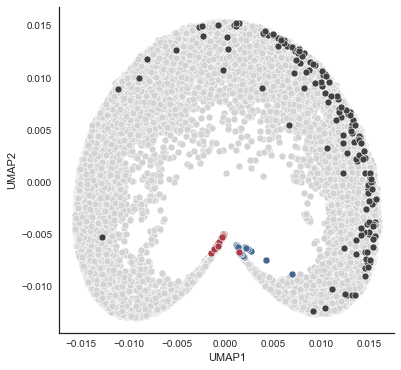

In [30]:
loc = '../../Zenodo_IRF3/DeepLearning/Transfer/Features/tf_df_feats_ch6_grped_sgonly.hdf'
topn = 50
meanthresh = 0.04
colstart = 'cnn'
grped = grp_df(loc)
dfu = pd.concat([pd.DataFrame(gphate_pex_tf[:,:2]),grped,pd.DataFrame(gop_pex_tf.diff_potential)],axis = 1)
dfu.columns = ['PHATE1','PHATE2'] + list(grped.columns) + list(np.repeat('phate',gop_pex_tf.diff_potential.shape[1]))

nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

tfup=dfu.query('pex_cell_max > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
tfdown=dfu.query('pex_cell_max < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

#

gpex_tfu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_pex_tf, name = 'pex_transfer',
                                                      geneslow = tfdown, geneshigh = tfup)

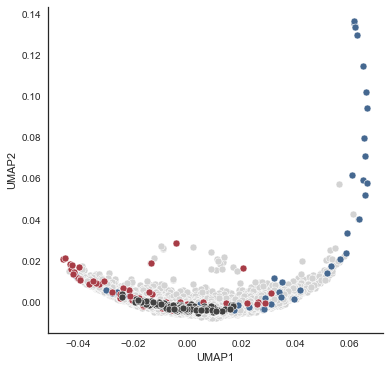

In [34]:
loc = '../../Zenodo_IRF3/DeepLearning/Autoencoder/Features/ae_df_feats_ch6_grped_sgonly.hdf'
topn = 50
meanthresh = 0.04
colstart = 'ae'
grped = grp_df(loc)
dfu = pd.concat([pd.DataFrame(gphate_pex_ae[:,:2]),grped,pd.DataFrame(gop_pex_ae.diff_potential)],axis = 1)
dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_pex_ae.diff_potential.shape[1]))

nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

aeup=dfu.query('pex_cell_max > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
aedown=dfu.query('pex_cell_max < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

#

gpex_aeu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_pex_ae, name = 'pex_autoencoder',
                                                      geneslow = aedown, geneshigh = aeup)

In [27]:
# run enrichr on defined features
enr = gp.enrichr(gene_list=pd.Series(list(pexdowngenesvolcano)),
                 gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                           'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                 organism='Human', 
                 outdir='../Data/F3/enrichrterms/pex_defined_enrichr_low',
                 cutoff=0.05 
                )

enr = gp.enrichr(gene_list=pd.Series(list(pexupgenesvolcano)),
                 gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                           'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                 organism='Human', 
                 outdir='../Data/F3/enrichrterms/pex_defined_enrichr_high',
                 cutoff=0.05 
                )



##### Plot figure

<Figure size 468x216 with 0 Axes>

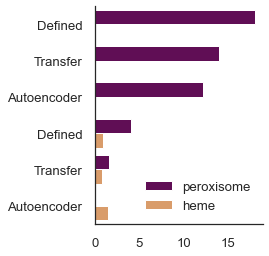

In [35]:

pd.options.mode.chained_assignment = None

names = ['Defined down', 'Defined up', 'Autoencoder down', 'Autoencoder up', 'Transfer down', 'Transfer up']


locs = ['../Data/F3/enrichrterms/pex_defined_enrichr_low/GO_Biological_Process_2018.Human.enrichr.reports.txt',
       '../Data/F3/enrichrterms/pex_defined_enrichr_high/GO_Biological_Process_2018.Human.enrichr.reports.txt',
       '../Data/F3/enrichrterms/pex_autoencoder_phate_enrichr_low/GO_Biological_Process_2018.Human.enrichr.reports.txt',
       '../Data/F3/enrichrterms/pex_autoencoder_phate_enrichr_high/GO_Biological_Process_2018.Human.enrichr.reports.txt',
       '../Data/F3/enrichrterms/pex_transfer_phate_enrichr_low/GO_Biological_Process_2018.Human.enrichr.reports.txt',
       '../Data/F3/enrichrterms/pex_transfer_phate_enrichr_high/GO_Biological_Process_2018.Human.enrichr.reports.txt',
       ]

results = []
for i in range(len(locs)):
    res = pd.read_table(locs[i])
    res['Dataset'] = names[i]
    results.append(res)
results = pd.concat(results)
pexheme = results[results.Term.str.contains('GO:0006783')]


sns.set(font_scale=1.2) 
sns.set_style("white")
plt.figure(figsize = (6.5,3))
names = ['Defined down', 'Defined up', 'Autoencoder down', 'Autoencoder up', 'Transfer down', 'Transfer up']
locs = ['../Data/F3/enrichrterms/pex_defined_enrichr_low/GO_Cellular_Component_2018.Human.enrichr.reports.txt',
       '../Data/F3/enrichrterms/pex_defined_enrichr_high/GO_Cellular_Component_2018.Human.enrichr.reports.txt',
       '../Data/F3/enrichrterms/pex_autoencoder_phate_enrichr_low/GO_Cellular_Component_2018.Human.enrichr.reports.txt',
       '../Data/F3/enrichrterms/pex_autoencoder_phate_enrichr_high/GO_Cellular_Component_2018.Human.enrichr.reports.txt',
       '../Data/F3/enrichrterms/pex_transfer_phate_enrichr_low/GO_Cellular_Component_2018.Human.enrichr.reports.txt',
       '../Data/F3/enrichrterms/pex_transfer_phate_enrichr_high/GO_Cellular_Component_2018.Human.enrichr.reports.txt',
       ]

results = []
for i in range(len(locs)):
    res = pd.read_table(locs[i])
    res['Dataset'] = names[i]
    results.append(res)
results = pd.concat(results)
pex = results[results.Term.str.contains('GO:0005777')]
pexsmall = pex.loc[pex.Dataset == 'Autoencoder down']
pexsmall['Dataset'] = 'Autoencoder up'
pexsmall['Adjusted P-value'] = 1

pex = pd.concat([pex,pexsmall])
pex = pd.concat([pex, pexheme])

fig, ax = plt.subplots()
fig.set_size_inches(3,4)

pex.Term = [s.split(' ')[0] for s in pex.Term]
sns.barplot(data = pex, y = 'Dataset', x = -np.log10(pex['Adjusted P-value']), palette = pal[3:], hue = 'Term',
           order = ['Defined down', 'Transfer down', 'Autoencoder down',
                   'Defined up', 'Transfer up', 'Autoencoder up'])
sns.despine(top = True, right = True)
plt.ylabel('')
plt.xlabel('')
labels = [item.get_text() for item in ax.get_yticklabels()]
labels = ['Defined', 'Transfer', 'Autoencoder','Defined', 'Transfer', 'Autoencoder']

ax.set_yticklabels(labels)
plt.legend(frameon = False, loc = 'lower right')
plt.savefig('pex_barplot.tif',dpi=300,bbox_inches='tight')
plt.show()



### Pex intensity barplot

In [18]:
np.sort(pd.unique(df.well))

array(['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09',
       'A10', 'A11', 'A12', 'D01', 'D02', 'D03', 'D04', 'D05', 'D06',
       'D07', 'D08', 'D09', 'D10', 'D11', 'D12', 'G01', 'G02', 'G03',
       'G04', 'G05', 'G06', 'G07', 'G08'], dtype=object)

In [17]:

df = pd.read_hdf('../../Zenodo_IRF3/Figure3/Pex_Intensity/Extracted Data/m154.hdf')
df.gene = df.gene.astype('category')

sorter = ['nontargeting', 'SEPHS1', 'VHL', 'ZCCHC14']
df.gene.cat.set_categories(sorter, inplace=True)
df = df.sort_values(["gene"])
df.gene = df.gene.astype('string')

#

1189491
gate applied, retained  78 % of data
number nt 6000
channel_cell_75
auc done
           gene  n_sg  fisher_combined_chi          pval  fdr_bh_adj_p  \
0  nontargeting   2.0             3.316965  5.062488e-01  5.062488e-01   
1        SEPHS1   2.0            17.712915  1.404139e-03  1.872185e-03   
2           VHL   2.0            28.889184  8.233220e-06  1.646644e-05   
3       ZCCHC14   2.0            65.115029  2.433553e-13  9.734212e-13   

   significant pval_text  
0        False            
1         True        **  
2         True      ****  
3         True      ****  
grped done
            gene           sgRNA  rep  channel_cell_75 sgRNA_num
0   nontargeting  nontargeting_0    3         0.013142       sg0
1   nontargeting  nontargeting_1    4        -0.012294       sg1
2   nontargeting  nontargeting_0    4        -0.024631       sg0
3   nontargeting  nontargeting_1    1        -0.005047       sg1
4   nontargeting  nontargeting_1    2        -0.027217       sg1
5   nont

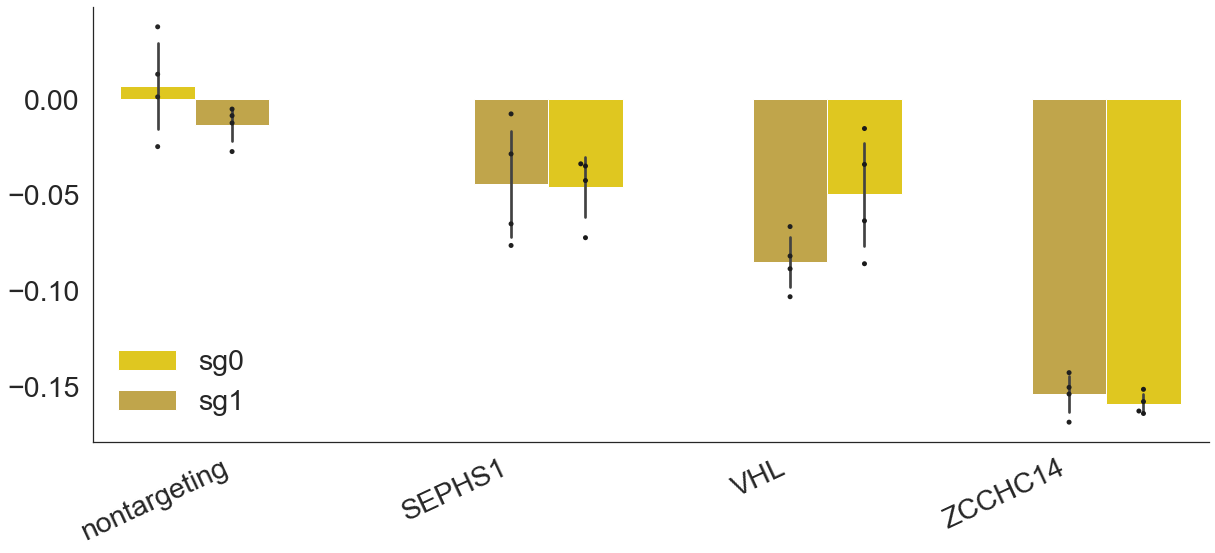

In [69]:
from ops.firedove_barplots_v2 import *


aucs, grped = produce_barplot_general(df,  df_name = 'm154', pshow = True, 
                                    genes = pd.unique(df.gene),
                        gate = '100 < i <1380 & 100 < j < 1380 & area <= 700 & area > 50',
                    replist = [1,2,3],  nbins=50,  
                        feature='channel_cell_75', plot_nt = False, range_vals = (0,60000), pal = 'yellow',
                   alpha=.05, pval_sort = False)

##

### SeV volcano plot

In [37]:
xls = pd.ExcelFile('../Data/TableS4.xls')
df = pd.read_excel(xls, 'SeV_cell_median')
df.index = df.gene_symbol

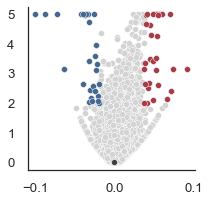

In [43]:
fdrthresh = .01
topn = 30
sns.set_style('white')
sevdowngenesvolcano = (df.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[:topn].index)
sevupgenesvolcano = (df.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[-topn:].index)

plt.figure(figsize = (3,3))
sns.scatterplot(x = df['mean'], y = -np.log10(df.fdr_bh_adj_p), color=mcolors.to_rgba('#d3d3d3'))
sns.scatterplot(x = df[df.index == "nontargeting"]['mean'], y = -np.log10(df[df.index== "nontargeting"].fdr_bh_adj_p), 
                color = mcolors.to_rgba('#404040'))
sns.scatterplot(x = df[df.index.isin(sevdowngenesvolcano)]['mean'], 
                y = -np.log10(df[df.index.isin(sevdowngenesvolcano)].fdr_bh_adj_p), color = pal[1])
sns.scatterplot(x = df[df.index.isin(sevupgenesvolcano)]['mean'], 
                y = -np.log10(df[df.index.isin(sevupgenesvolcano)].fdr_bh_adj_p), color = pal[0])

sns.despine(top = True, right = True)
plt.xlabel('')
plt.ylabel('')
plt.savefig('../../../IRF3 Paper/Figures/F3/volcano_sev_cell_median.tif', dpi = 600, bbox_inches = 'tight')
plt.show()
#

### SeV Gene Ontology

##### Find GO terms

In [41]:
loc = '../../Zenodo_IRF3/DeepLearning/Transfer/Features/tf_df_feats_ch4_grped_sgonly.hdf'
grped = grp_df(loc)
gphate_sev_tf, gop_sev_tf = calc_phate(grped, colstart = 'cnn')

loc = '../../Zenodo_IRF3/DeepLearning/Autoencoder/Features/ae_df_feats_ch4_grped_sgonly.hdf'
grped = grp_df(loc)
gphate_sev_ae, gop_sev_ae = calc_phate(grped, colstart = 'ae')

Calculating PHATE...
  Running PHATE on 19076 observations and 1240 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.86 seconds.
    Calculating KNN search...
    Calculated KNN search in 10.01 seconds.
    Calculating affinities...
    Calculated affinities in 0.22 seconds.
  Calculated graph and diffusion operator in 12.13 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.26 seconds.
    Calculating KMeans...
    Calculated KMeans in 21.17 seconds.
  Calculated landmark operator in 24.96 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.58 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 151.54 seconds.
Calculated PHATE in 189.22 seconds.
Calculating PHATE...
  Running PHATE on 19076 observations and 1039 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.98 seconds.
    Calculating KNN se

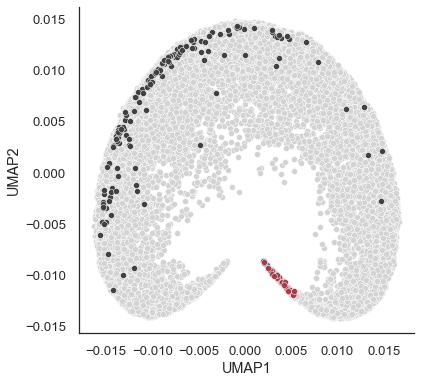

In [44]:
loc = '../../Zenodo_IRF3/DeepLearning/Transfer/Features/tf_df_feats_ch4_grped_sgonly.hdf'
topn = 30
meanthresh = 0.04
colstart = 'cnn'
grped = grp_df(loc)
dfu = pd.concat([pd.DataFrame(gphate_sev_tf[:,:2]),grped,pd.DataFrame(gop_sev_tf.diff_potential)],axis = 1)
dfu.columns = ['PHATE1','PHATE2'] + list(grped.columns) + list(np.repeat('phate',gop_sev_tf.diff_potential.shape[1]))

nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

tfup=dfu.query('sev_cell_median > @meanthresh')[['gene','distance','sev_cell_median']].sort_values(['distance'], ascending=False)[:topn].gene
tfdown=dfu.query('sev_cell_median < - @meanthresh')[['gene','distance','sev_cell_median']].sort_values(['distance'], ascending=False)[:topn].gene

#

gsev_tfu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_sev_tf, name = 'sev_transfer',
                                                      geneslow = tfdown, geneshigh = tfup)

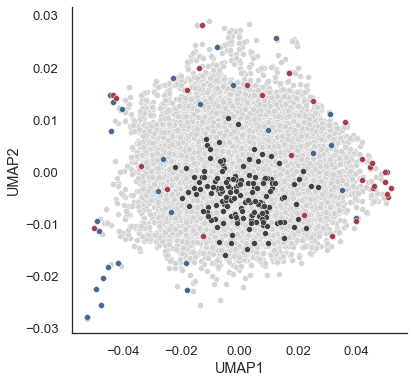

In [45]:
loc = '../../Zenodo_IRF3/DeepLearning/Autoencoder/Features/ae_df_feats_ch4_grped_sgonly.hdf'
topn = 30
meanthresh = 0.04
colstart = 'ae'
grped = grp_df(loc)
dfu = pd.concat([pd.DataFrame(gphate_sev_ae[:,:2]),grped,pd.DataFrame(gop_sev_ae.diff_potential)],axis = 1)
dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_sev_ae.diff_potential.shape[1]))

nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

aeup=dfu.query('sev_cell_median > @meanthresh')[['gene','distance','sev_cell_median']].sort_values(['distance'], ascending=False)[:topn].gene
aedown=dfu.query('sev_cell_median < - @meanthresh')[['gene','distance','sev_cell_median']].sort_values(['distance'], ascending=False)[:topn].gene

#

gsev_aeu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_sev_ae, name = 'sev_autoencoder',
                                    geneslow = aedown, geneshigh = aeup)


####

In [46]:
# run enrichr on defined features
enr = gp.enrichr(gene_list=pd.Series(list(sevdowngenesvolcano)),
                 gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                           'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                 organism='Human', 
                 outdir='../Data/F3/enrichrterms/sev_defined_enrichr_low',
                 cutoff=0.05 
                )

enr = gp.enrichr(gene_list=pd.Series(list(sevupgenesvolcano)),
                 gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                           'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                 organism='Human', 
                 outdir='../Data/F3/enrichrterms/sev_defined_enrichr_high',
                 cutoff=0.05 
                )



##### Plot figure

<Figure size 468x216 with 0 Axes>

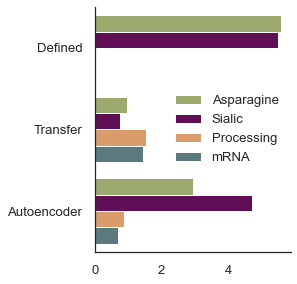

In [49]:
sns.set(font_scale=1.2) 
sns.set_style("white")
plt.figure(figsize = (6.5,3))
names = ['Defined', 'Autoencoder', 'Transfer']

locs = ['../Data/F3/enrichrterms/sev_defined_enrichr_low/Reactome_2016.Human.enrichr.reports.txt',
       '../Data/F3/enrichrterms/sev_autoencoder_phate_enrichr_low/Reactome_2016.Human.enrichr.reports.txt',
       '../Data/F3/enrichrterms/sev_transfer_phate_enrichr_low/Reactome_2016.Human.enrichr.reports.txt',
       ]



results = []
for i in range(len(locs)):
    
    res = pd.read_table(locs[i])
    res['Dataset'] = names[i]
    results.append(res)
results = pd.concat(results)

results
sev = results[results.Term.str.contains('R-HSA-4085001|R-HSA-446203|R-HSA-72203|R-HSA-72163')]
sev
sevsmall = sev.loc[(sev.Term.str.contains('R-HSA-72203|R-HSA-72163')) & (sev.Dataset == 'Transfer')]
sevsmall['Dataset'] = 'Defined'
sevsmall['Adjusted P-value'] = 1
sev = pd.concat([sev,sevsmall])

fig, ax = plt.subplots()
fig.set_size_inches(3.5,4.5)

sev.Term = [s.split(' ')[0] for s in sev.Term]
sns.barplot(data = sev, y = 'Dataset', x = -np.log10(sev['Adjusted P-value']), palette = pal[2:], hue = 'Term',
            order = ['Defined', 'Transfer', 'Autoencoder'])
sns.despine(top = True, right = True)
plt.ylabel('')
plt.xlabel('')
labels = [item.get_text() for item in ax.get_yticklabels()]

ax.set_yticklabels(labels)
plt.legend(frameon = False)
plt.show()